In [1]:
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(tf.__version__)

2.16.2


In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:

print(np.isnan(x_train).any())
print(np.isnan(y_train).any())
print(np.isnan(x_test).any())
print(np.isnan(y_test).any())

False
False
False
False


In [4]:
input_shape = (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.

In [5]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

2024-12-04 13:52:37.375266: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-04 13:52:37.375295: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-04 13:52:37.375308: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-04 13:52:37.375507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-04 13:52:37.375531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


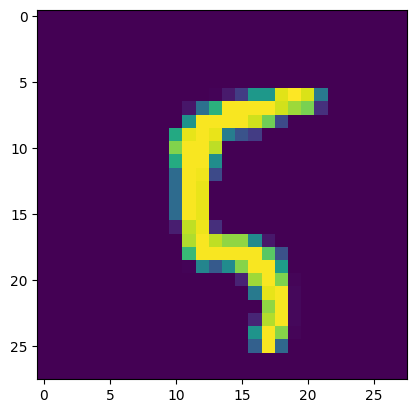

In [6]:
plt.imshow(x_train[100][:, :, 0])
print(y_train[100])

In [7]:
batch_size = 32
num_classes = 10
epochs = 10

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

/opt/anaconda3/envs/embedded-metal/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>.95):
      print('\nReached (threshold)% accuracy so cancelling training!')
      self.model.stop_training = True

callbacks = myCallback()

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/10


2024-12-03 09:21:41.436996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - acc: 0.8603 - loss: 0.4423 - val_acc: 0.9870 - val_loss: 0.0427
Epoch 2/10
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.9761 - loss: 0.0828
Reached (threshold)% accuracy so cancelling training!
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - acc: 0.9761 - loss: 0.0828 - val_acc: 0.9903 - val_loss: 0.0355


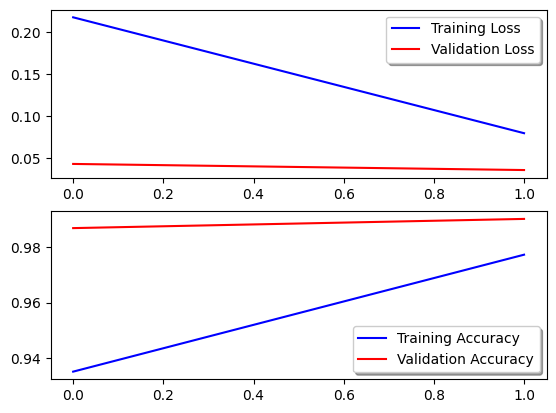

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='r',label='Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)
plt.savefig('training_result.png')
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9869 - loss: 0.0376


In [16]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)
confusion_mat = tf.math.confusion_matrix(Y_true, Y_pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


<Axes: >

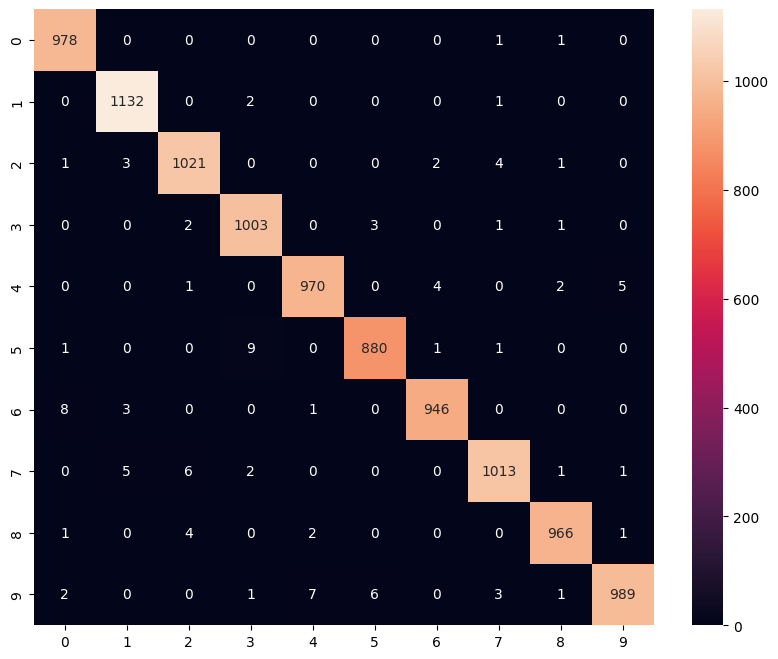

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='g')

In [19]:
model.save('model.keras')